# **EDA POS CASH**

## **Table of contents**

* [Our goals](#Our-goals)
* [About the data](#About-the-data)
* [Generalities](#Generalities)
* [Missing values](#Missing-values)
* [Raw features description](#Raw-features-description)
* [Features creation](#Features-creation)
* [Summary](#Summary)

In [1]:
import sys
import os
from pathlib import Path
project_root = str(Path(os.getcwd()).parent)
if project_root not in sys.path:
    sys.path.append(project_root)

from utilities import (
    stat_utilities,
    plot_utilities
)

from utilities.stat_utilities import get_missing_values
from utilities.plot_utilities import (
    to_percent, 
    plot_triangle_corr_matrix, 
    Rstyle_spines
)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

In [2]:
data_dir = f"../sample_data/"
sample_pos = pd.read_parquet(data_dir + "sample_POS_CASH_balance.parquet")

## **Our goals**

<div style="background-color: #f8d7dA; padding: 10px; border-radius: 5px;">
    
In this notebook we aim at:
* **Exploring the Installment Dataset:** Perform EDA to identify potential anomalies.
* **Creating New Features:** Apply two-stage aggregation on SK_ID_PREV and SK_ID_CURR.
* **Building Functions:** Create functions to compute new features and join them with the main dataframe.
* **Visualizing Relationships:** Visualize how the features relate to each other.
</div>

## **About the data**

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
    
**POS** stands for **Point of Sale**, which refers to a location or system where a retail transaction takes place, such as a physical checkout counter in a store or a digital checkout system. **POS Cash** often refers to cash withdrawn at a point-of-sale terminal, like when a customer gets cash back during a purchase using a debit card. Home Credit lends money to applicants through either Cash or Consumer loans and provides credit cards that can be used for payments or cash withdrawals.
</div>

## **Generalities**

In [3]:
sample_pos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1708949 entries, 0 to 10001356
Data columns (total 8 columns):
 #   Column                 Dtype   
---  ------                 -----   
 0   SK_ID_PREV             int32   
 1   SK_ID_CURR             int32   
 2   MONTHS_BALANCE         int8    
 3   CNT_INSTALMENT         float32 
 4   CNT_INSTALMENT_FUTURE  float32 
 5   NAME_CONTRACT_STATUS   category
 6   SK_DPD                 int16   
 7   SK_DPD_DEF             int16   
dtypes: category(1), float32(2), int16(2), int32(2), int8(1)
memory usage: 48.9 MB


<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">

Here is a concise description of each feature:
* **`MONTHS_BALANCE`:** Month of balance relative to application date (-1 means the information to the freshest monthly snapshot, 0 means the information at application - often it will be the same as -1 as many banks are not updating the information to Credit Bureau regularly )
* **`CNT_INSTALMENT`:** Term of previous credit (can change over time)
* **`CNT_INSTALMENT_FUTURE`:** Installments left to pay on the previous credit
* **`NAME_CONTRACT_STATUS`:** Contract status during the month
* **`SK_DPD`:** DPD (days past due) during the month of previous credit
* **`SK_DPD_DEF`:** DPD during the month with tolerance (debts with low loan amounts are ignored) of the previous credit
</div>

## **Missing values**

In [4]:
get_missing_values(sample_pos)

,Count,Percent
CNT_INSTALMENT,4580,0.268001
CNT_INSTALMENT_FUTURE,4576,0.267767
SK_ID_PREV,0,0.000000
SK_ID_CURR,0,0.000000
MONTHS_BALANCE,0,0.000000
NAME_CONTRACT_STATUS,0,0.000000
SK_DPD,0,0.000000
SK_DPD_DEF,0,0.000000


<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
This time the data set seems quite clean with only a very small number of missing values. Let's find out where do these come from.
</div>

In [5]:
sample_pos[sample_pos["CNT_INSTALMENT"].isna() == True].head(5)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
8119,1910110,278474,-33,NaN,NaN,Signed,0,0
8639,2346411,264498,-8,NaN,NaN,Signed,0,0
11822,1080691,372634,-12,NaN,NaN,Signed,0,0
11833,2240429,234118,-10,NaN,NaN,Signed,0,0
15681,1857366,282087,-18,NaN,NaN,Approved,0,0


In [6]:
sample_pos[sample_pos["CNT_INSTALMENT"].isna() == True][
    "NAME_CONTRACT_STATUS"
].value_counts()

NAME_CONTRACT_STATUS
Signed                   3546
Returned to the store     523
Approved                  486
Active                     23
Canceled                    2
Amortized debt              0
Completed                   0
Demand                      0
XNA                         0
Name: count, dtype: int64

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
The vast majority of the missing values correspond to loans that were either canceled, returned to the store, or very recently signed, approved, or activated, meaning the reimbursement schedule is not yet available. We'll leave these missing values blank, as there is no clear method for imputing them.
</div>

## **Raw features description**

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
Let's get a quick look on how the raw features are distributed.
</div>

In [7]:
pos_num_cols = [
    col
    for col in sample_pos.select_dtypes(include="number").columns
    if not col.startswith("SK_ID")
]
pos_cat_cols = list(sample_pos.select_dtypes(include="category").columns.values)

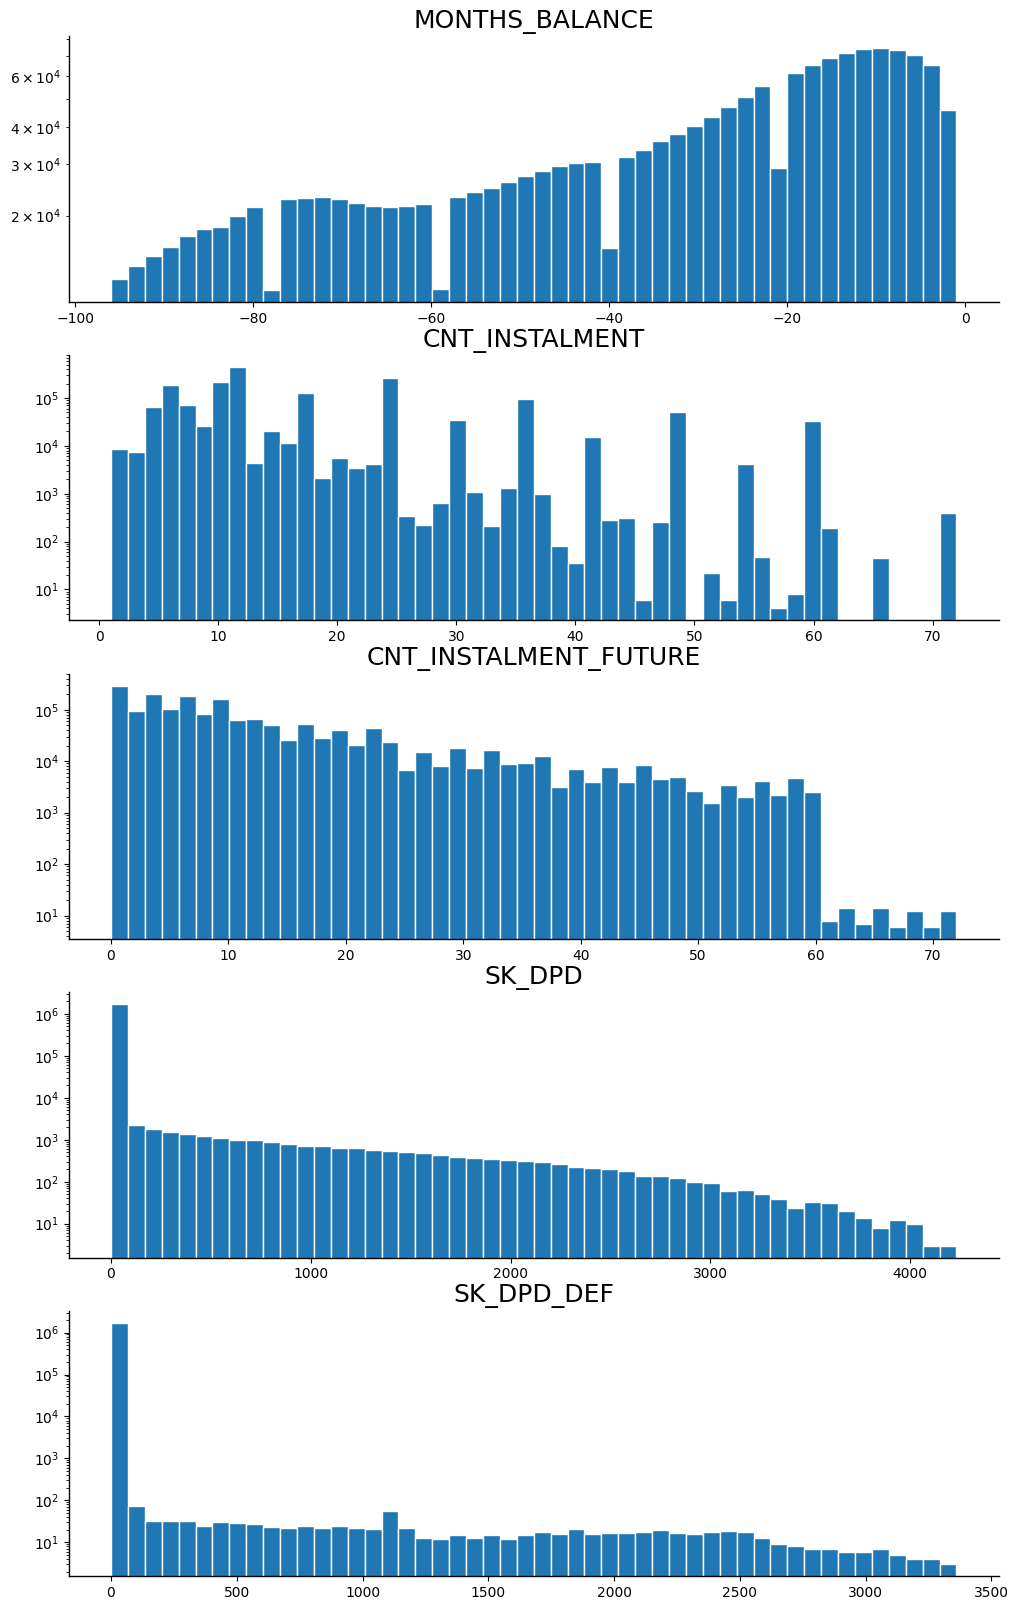

In [8]:
fig, axs = plt.subplots(len(pos_num_cols), 1, figsize=(12, 4 * len(pos_num_cols)))
for i, feature in enumerate(pos_num_cols):
    N, bins, patches = axs[i].hist(
        sample_pos[feature], bins=50, color="C0", edgecolor="w"
    )
    axs[i].set_yscale("log")
    axs[i].set_title(feature, fontsize=18)
    Rstyle_spines(axs[i], lw=1)

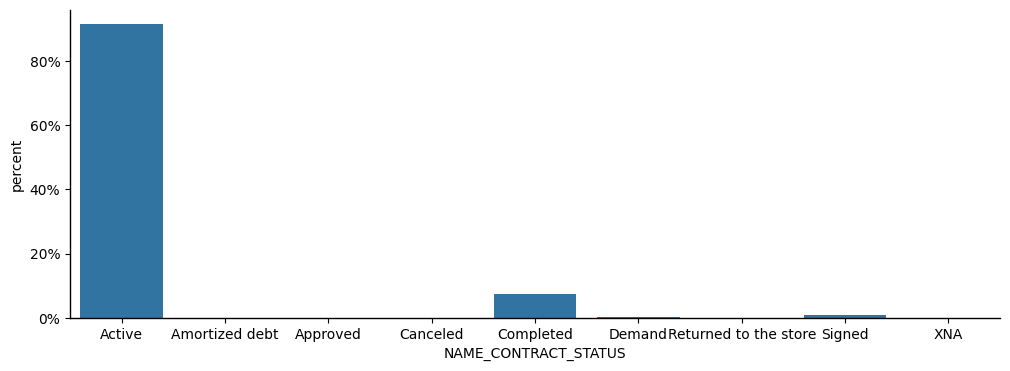

In [9]:
fig, ax = plt.subplots(figsize=(12, 4))
sns.countplot(data=sample_pos, x="NAME_CONTRACT_STATUS", ax=ax, stat="percent")
Rstyle_spines(ax, lw=1)
ax.tick_params(labelsize=10)
ax.yaxis.set_major_formatter(FuncFormatter(to_percent))

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
A couple of observations:

* No anomalies were detected among the features.
* It's expected to find a high number of loans marked as active, as each month of activity corresponds to one occurrence in the dataset.
</div>

## **Features creation**

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
    
To move forward with feature engineering from the POS CASH dataset, we will design a function that will apply two layers of aggregation over `SK_ID_PREV` (individual loans) and `SK_ID_CURR` (loan applicants). We'll try to generate new features that capture meaningful patterns in repayment behavior, which are likely to help our model predict defaults.
Here are the features we plan to create:

* **Features:**
    * **Number of remaining instalments `CNT_INSTALMENT_FUTURE`:**
        * **Concept:** This will measure how many instalment does the loan applicant has yet to pay on his credits.
        * **Aggregation Strategy:**
            * **Step 1 (`SK_ID_PREV`):** Get the minimum (**MIN**) of `CNT_INSTALMENT_FUTURE` for each loan
            * **Step 2 (`SK_ID_CURR`):** For each applicant, aggregate this information using the mean (**AVG**) and the sum (**SUM**).
    * **Number of instalments `CNT_INSTALMENT`:**
        * **Concept:** This will measure how many instalments are supposed to take place
        * **Aggregation Strategy:**
            * **Step 1 (`SK_ID_PREV`):** Get the maximum (**MAX**) of `CNT_INSTALMENT` for each loan
            * **Step 2 (`SK_ID_CURR`):** For each applicant, aggregate this information using the mean (**AVG**) and the sum (**SUM**).
    * **Number of days past due `SK_DPD`:**
        * **Concept:** This will tell us if the loan applicant was paying his instalments in time or not, and more important if he has accumulated some unpaid instalments
        * **Aggregation Strategy:**
            * **Step 1 (`SK_ID_PREV`):** Get  the maximum (**MAX**) of `SK_DPD` for each loan and this over different time windows: **EVER**, **LAST_YEAR** and **LAST_3_MONTHS**.
            * **Step 2 (`SK_ID_CURR`):** For each applicant, aggregate this information using the mean (**AVG**)
    * **Number of days past due with tolerance `SK_DPD_DEF`:**
        * **Concept:** This will tell us if the loan applicant was paying his instalments in time or not, and more important if he has accumulated some unpaid instalments and how the Home Credit was adjusting its tolerance towards it.
        * **Aggregation Strategy:**
            * **Step 1 (`SK_ID_PREV`):** Get the maximum (**MAX**) of `SK_DPD_DEF` for each loan and this over different time windows: **EVER**, **LAST_YEAR** and **LAST_3_MONTHS**.
            * **Step 2 (`SK_ID_CURR`):** For each applicant, aggregate this information using the mean (**AVG**)
    * **Ratio of Number of days past due with tolerance vs Number of days past due `SK_DPD_DEF` / `SK_DPD`:**
        * **Concept:** This will tell us how the relation between the number of days past due compared with the number of tolerated days past due
        * **Aggregation Strategy:**
            * **Step 1 (`SK_ID_PREV`):** Get  the maximum (**MAX**) of `SK_DPD_DEF` / `SK_DPD` for each loan and this over different time windows: **EVER**, **LAST_YEAR** and **LAST_3_MONTHS**.
            * **Step 2 (`SK_ID_CURR`):** For each applicant, aggregate this information using the mean (**AVG**)
    * **Status of the loans `NAME_CONTRACT_STATUS`:**
        * **Concept:** This will tell us what are the status of the different POS CASH loans of the applicant
        * **Aggregation Strategy:**
            * **Step 1 (`SK_ID_PREV`):** We need to get the status for the last update. To that end we'll first order the datframe using the `MONTHS_BALANCE` feature.
            * **Step 2:** We will one-hot encode the `NAME_CONTRACT_STATUS`.
            * **Step 2 (`SK_ID_CURR`):** For each applicant, aggregate this information using the sum (**SUM**)


All this should take place within a function that will, in order, do:
* **Aggregation:** Perform first (`SK_ID_PREV`) and second (`SK_ID_CURR`) aggregations.
* **Output:** The function will return a dataframe with the new features, ready to be joined with the main datframe.

This feature engineering step will create new variables that capture deeper insights into loan repayment behavior. These features are expected to improve the classifier’s performance by adding nuanced information about the financial habits of loan applicants. The function must be adaptable for integration into a full preprocessing pipeline within scikit-learn.
</div>

In [10]:
def compute_first_agg_pos_cash(df_pos_cash: pd.DataFrame) -> pd.DataFrame:
    # We will now proceed to the first aggregation, this one will take place over SK_ID_PREV
    # We first compute the ratio
    df_pos_cash["RATIO_DPD_DEF_DPD"] = df_pos_cash["SK_DPD_DEF"] / (
        df_pos_cash["SK_DPD"] + 0.0001
    )

    # We then order the dataset using MONTHS_BALANCE
    df_pos_cash.sort_values(by="MONTHS_BALANCE", ascending=False, inplace=True)

    # We compute LAST_STATUS_POS in the most efficient way (first much slower)
    last_status_pos = (
        df_pos_cash.groupby(["SK_ID_PREV", "SK_ID_CURR"])["NAME_CONTRACT_STATUS"]
        .nth(0)
        .rename("LAST_STATUS_POS")
    )

    last_status_pos = (
        pd.concat(
            [
                df_pos_cash.loc[last_status_pos.index][["SK_ID_PREV", "SK_ID_CURR"]],
                last_status_pos,
            ],
            axis=1,
        )
        .sort_values(by=["SK_ID_PREV", "SK_ID_CURR"])
        .set_index(["SK_ID_PREV", "SK_ID_CURR"])
    )

    # We'll start with non-temporal features
    agg_dict_all = {"CNT_INSTALMENT_FUTURE": ["min"], "CNT_INSTALMENT": ["max"]}
    features_all = df_pos_cash.groupby(["SK_ID_PREV", "SK_ID_CURR"]).agg(agg_dict_all)
    features_all.columns = [
        "_".join(col).upper() for col in features_all.columns.values
    ]
    features_all = pd.concat([last_status_pos, features_all], axis=1)

    # Now we can proceed with the temporal ones
    time_windows = [
        ("EVER", df_pos_cash),
        ("LAST_YEAR", df_pos_cash[df_pos_cash["MONTHS_BALANCE"].between(-12, -1)]),
        ("LAST_3_MONTHS", df_pos_cash[df_pos_cash["MONTHS_BALANCE"] > -3]),
    ]
    diff_features = []
    all_window_columns = []
    for window_name, window_df in time_windows:
        agg_dict_diff = {
            "SK_DPD": ["max"],
            "SK_DPD_DEF": ["max"],
            "RATIO_DPD_DEF_DPD": ["max"],
        }
        window_features = window_df.groupby(["SK_ID_PREV", "SK_ID_CURR"]).agg(
            agg_dict_diff
        )
        window_features.columns = [
            f"{col[0]}_{window_name.upper()}_{col[1].upper()}"
            for col in window_features.columns.values
        ]
        diff_features.append(window_features)
        all_window_columns += list(window_features.columns.values)

    # We can combine all the features, reset the index, fill the missing values for the temporal features by 0 and drop the SK_ID_PREV
    first_agg_features = (
        features_all.join(diff_features).reset_index().drop("SK_ID_PREV", axis=1)
    )
    first_agg_features[all_window_columns] = first_agg_features[
        all_window_columns
    ].fillna(0)

    return first_agg_features

In [11]:
def compute_second_agg_pos_cash(first_agg_features: pd.DataFrame) -> pd.DataFrame:
    dum_status = pd.get_dummies(
        first_agg_features["LAST_STATUS_POS"], dtype=np.int8, prefix="LAST_STATUS_POS"
    )

    first_agg_features = pd.concat([dum_status, first_agg_features], axis=1)
    first_agg_features.drop("LAST_STATUS_POS", axis=1, inplace=True)

    status_columns = [
        col for col in first_agg_features.columns if col.startswith("LAST_STATUS")
    ]
    temporal_columns = [
        col
        for col in first_agg_features.columns
        if any(p in col for p in ["EVER", "LAST_YEAR", "LAST_3_MONTHS"])
    ]

    # Create the aggregation dictionaries
    agg_dict = {col: "sum" for col in status_columns}
    agg_temp = {col: ["mean"] for col in temporal_columns}
    agg_misc = {
        "CNT_INSTALMENT_FUTURE_MIN": ["mean", "sum"],
        "CNT_INSTALMENT_MAX": ["mean", "sum"],
    }

    agg_dict.update(agg_temp)
    agg_dict.update(agg_misc)

    # Perform the second aggregation
    second_agg_features = first_agg_features.groupby("SK_ID_CURR").agg(agg_dict)
    second_agg_features.columns = [
        "POS_CASH_" + "_".join(col).upper()
        for col in second_agg_features.columns.values
    ]

    return second_agg_features.reset_index()

In [12]:
def compute_features_pos_cash(df_pos_cash: pd.DataFrame) -> pd.DataFrame:
    df_pos_cash_ = df_pos_cash.copy()

    # Compute the first agg features (over SK_ID_PREV)
    first_agg = compute_first_agg_pos_cash(df_pos_cash_)

    # Compute the second agg features (over SK_ID_CURR)
    second_agg = compute_second_agg_pos_cash(first_agg)

    # Reset the index to be SK_ID_CURR
    second_agg.set_index("SK_ID_CURR", inplace=True)

    return second_agg

In [13]:
pos_cash_features = compute_features_pos_cash(sample_pos)
pos_cash_features.head(5)

,POS_CASH_LAST_STATUS_POS_ACTIVE_SUM,POS_CASH_LAST_STATUS_POS_AMORTIZED DEBT_SUM,POS_CASH_LAST_STATUS_POS_APPROVED_SUM,POS_CASH_LAST_STATUS_POS_CANCELED_SUM,POS_CASH_LAST_STATUS_POS_COMPLETED_SUM,POS_CASH_LAST_STATUS_POS_DEMAND_SUM,POS_CASH_LAST_STATUS_POS_RETURNED TO THE STORE_SUM,POS_CASH_LAST_STATUS_POS_SIGNED_SUM,POS_CASH_LAST_STATUS_POS_XNA_SUM,POS_CASH_SK_DPD_EVER_MAX_MEAN,POS_CASH_SK_DPD_DEF_EVER_MAX_MEAN,POS_CASH_RATIO_DPD_DEF_DPD_EVER_MAX_MEAN,POS_CASH_SK_DPD_LAST_YEAR_MAX_MEAN,POS_CASH_SK_DPD_DEF_LAST_YEAR_MAX_MEAN,POS_CASH_RATIO_DPD_DEF_DPD_LAST_YEAR_MAX_MEAN,POS_CASH_SK_DPD_LAST_3_MONTHS_MAX_MEAN,POS_CASH_SK_DPD_DEF_LAST_3_MONTHS_MAX_MEAN,POS_CASH_RATIO_DPD_DEF_DPD_LAST_3_MONTHS_MAX_MEAN,POS_CASH_CNT_INSTALMENT_FUTURE_MIN_MEAN,POS_CASH_CNT_INSTALMENT_FUTURE_MIN_SUM,POS_CASH_CNT_INSTALMENT_MAX_MEAN,POS_CASH_CNT_INSTALMENT_MAX_SUM
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,
100003,1,0,0,0,2,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,1.0,10.000000,30.0
100026,0,0,0,0,2,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,21.000000,42.0
100030,0,0,0,0,2,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,3.500000,7.0
100039,1,0,0,0,2,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,17.333334,52.0
100043,1,0,0,0,2,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.000000,48.0,38.666668,116.0


<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">

We have computed various features from the POS CASH dataset. In the final pipeline, this newly created dataset will be merged with the main one, along with other datasets. Of course, some loan applicants may not yet have a loan with Home Credit, so they might be missing (i.e., no `SK_ID_CURR`). In such cases, the features we've created can easily be imputed with 0 for absent applicants.

Next, we'll explain and demonstrate how this step will be implemented in the future. Our pipeline needs to be both flexible and efficient, ensuring we only extract the necessary amount of information. For example, if we take a slice of the main dataframe (say, for cross-validation), we will extract the corresponding slice from other datasets. To achieve this, we will identify the `SK_ID_CURR` values from the main dataframe and retrieve only the relevant rows containing these `SK_ID_CURR` values in the other datasets. However, since our sample datasets were created specifically for this purpose, we'll simply demonstrate the process of pre-joining and joining. This way, we can observe how the newly created features relate to each other as well as to the target variable.
</div>

In [14]:
def join_pos_cash_with_app(
    app_df: pd.DataFrame, features_pos_cash: pd.DataFrame
) -> pd.DataFrame:
    sk_id_curr = pd.DataFrame(index=app_df.index)
    pre_joined = sk_id_curr.join(features_pos_cash, how="left").fillna(0)

    joined = app_df.join(pre_joined, how="left")
    return joined

In [15]:
sample_app = pd.read_parquet(
    data_dir + "sample_application.parquet", columns=["SK_ID_CURR", "TARGET"]
)
sample_app.set_index("SK_ID_CURR", inplace=True)
pos_cash_and_target = join_pos_cash_with_app(sample_app, pos_cash_features)

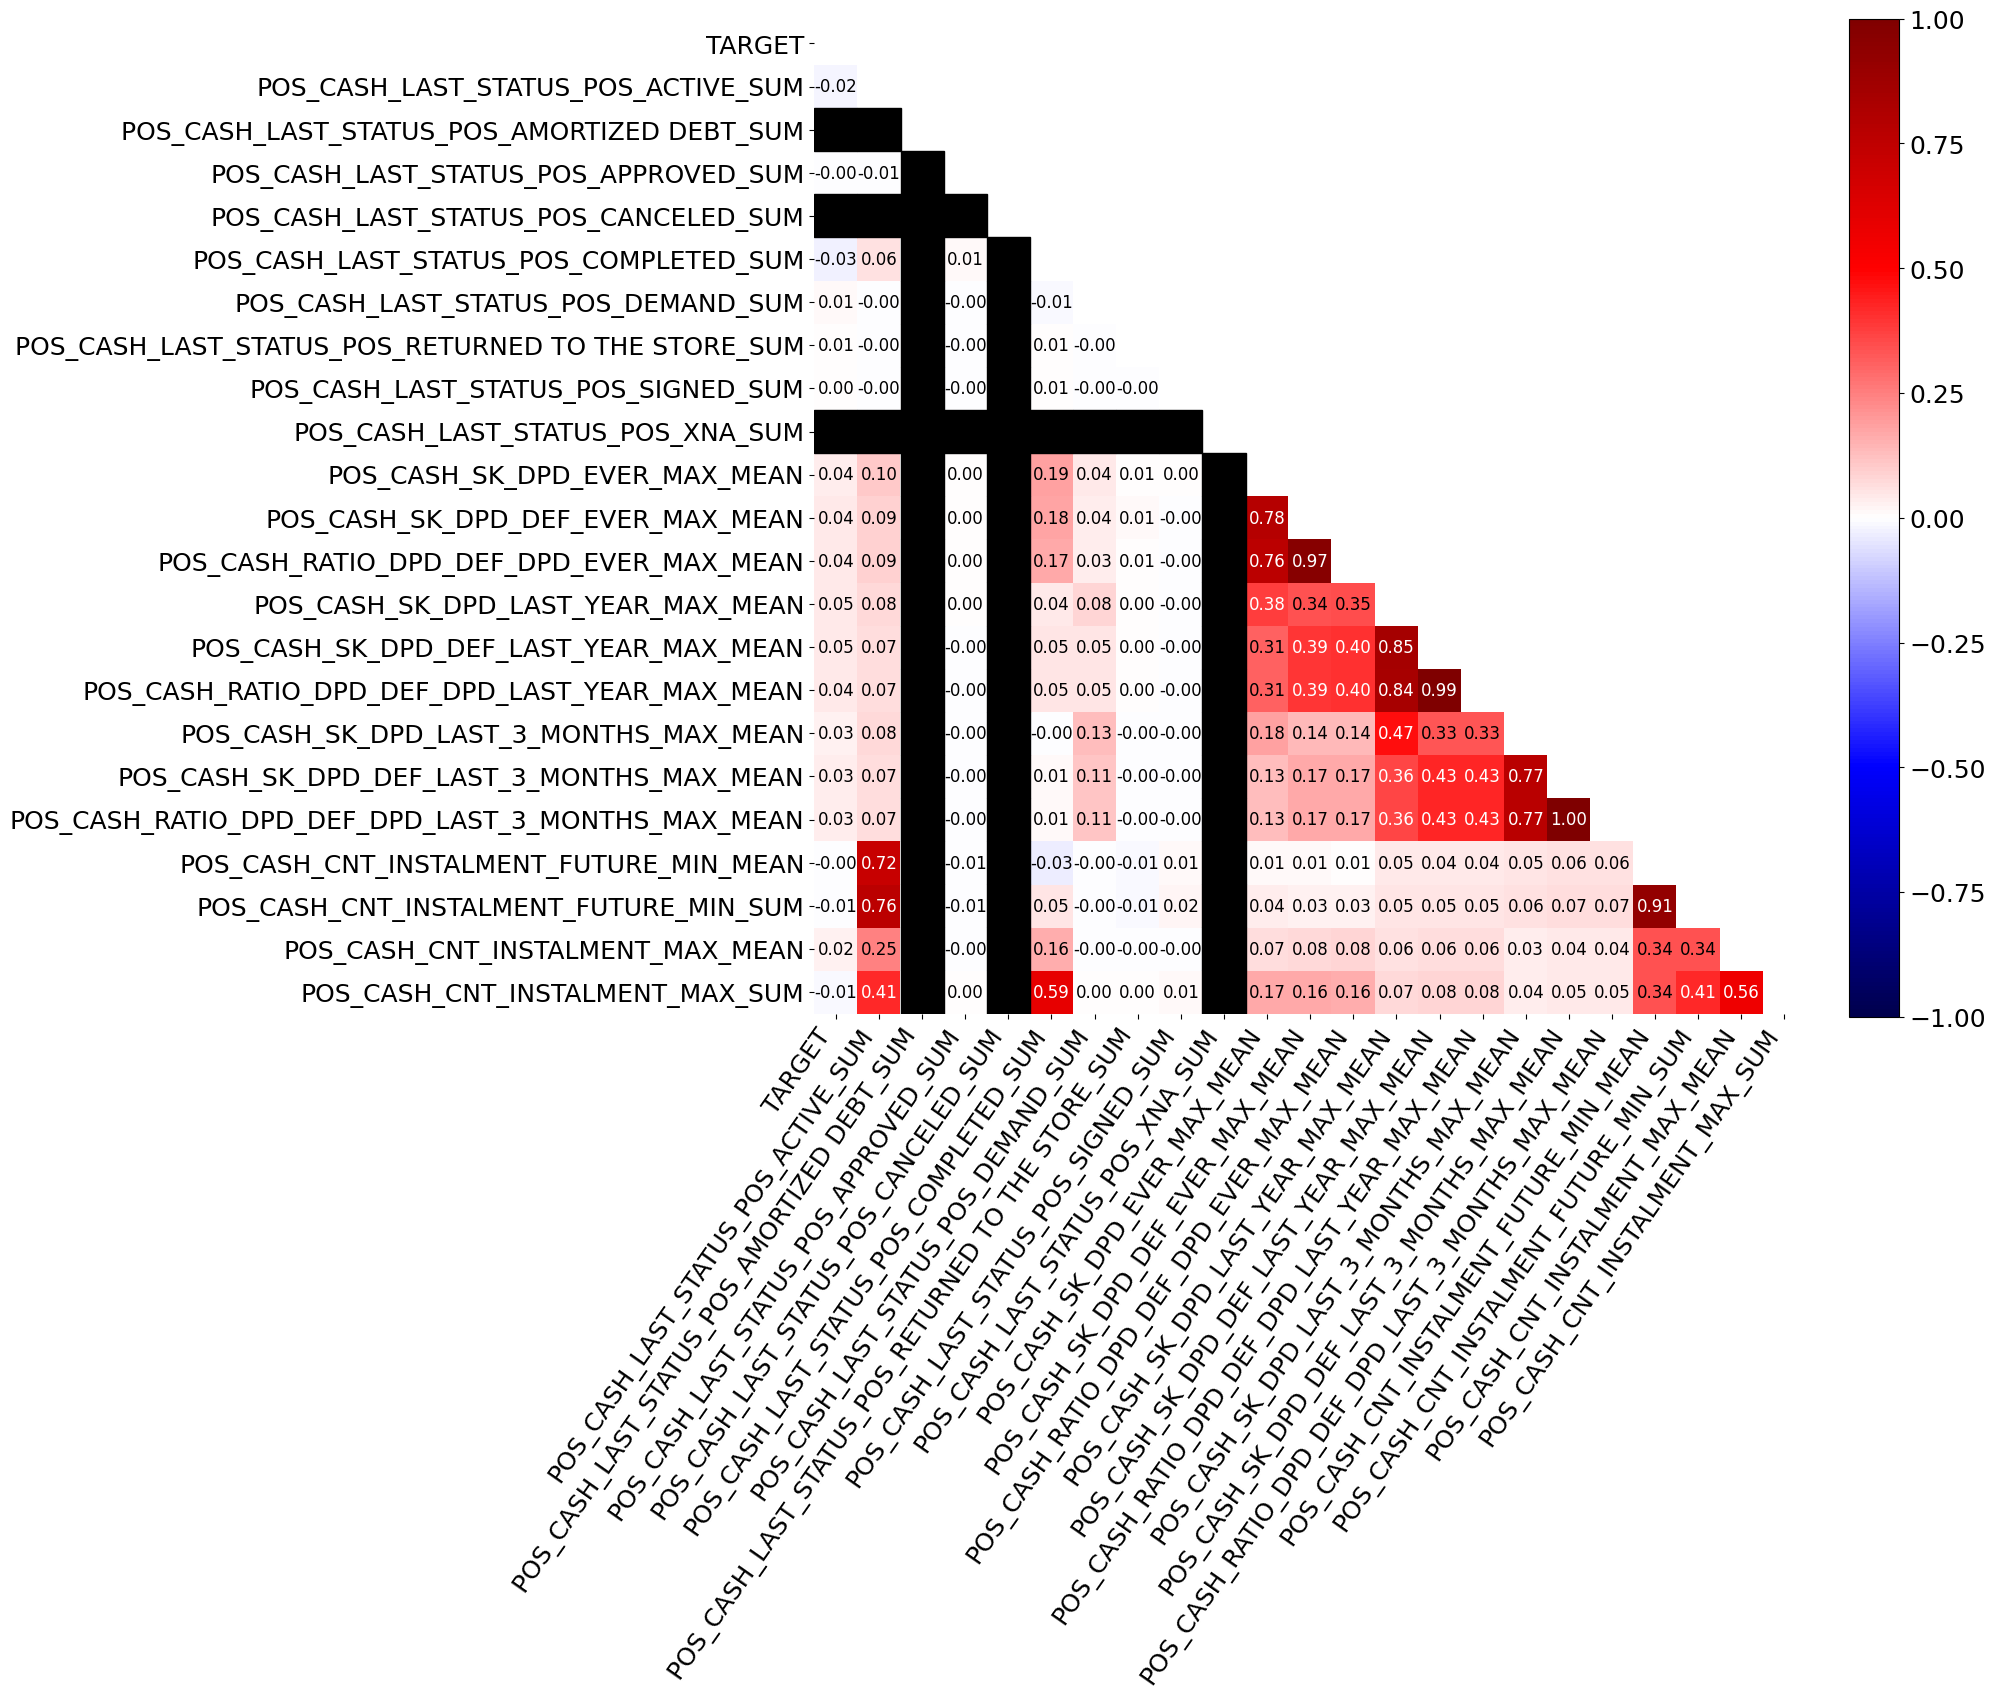

In [16]:
num_corr = pos_cash_and_target.corr(method="kendall")
fig, ax = plt.subplots(figsize=(14, 14))
plot_triangle_corr_matrix(num_corr, ax=ax, ticks_fs=18, annotation=True, annot_fs=12)

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
A few observations should be noted:

* We've computed many features that show a lot of similarities, with some being nearly identical, as indicated by a Kendall correlation coefficient close to 1. We are aware that accumulating such features could slow down our pipeline and potentially lead to overfitting. For now, we will proceed by training our first model with all the features combined, and later, we'll perform feature selection where many of these redundant features may be removed.
* Some features are also shown in black here, it means that no occurence of it was found. They will probably be irrelevant, we'll amost surely remove them later.
* Some of the new features show a slight relationship with the target variable, which is a positive sign for validating our approach. However, it doesn't yet tell us how these features will interact with others during model training.
</div>

## **Summary**

<div style="background-color: #f8d7dA; padding: 10px; border-radius: 5px;">
Here is a summary of our findings and actions:

* During the EDA, we identified some missing values. No strategy was yet found to impute them, but since they were just an infinitesimal fraction of the dataset, this should not matter much.
* We created 22 new features through a two-stage aggregation process. Some of these features are highly correlated with each other, which could pose issues later on (e.g., overfitting, reduced efficiency). Also some features have no variance since no occurence of it was found after the two stages aggregation. However, a few show a small but noticeable correlation with the target variable, making them potentially valuable.
* We developed the functions that will be used to compute these features and merge them with the main dataframe in the final pipeline.
</div>